In [1]:
import diff_gaussian_rasterization as dgr
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import bayes3d as b
import jax.numpy as jnp
from random import randint
import pytorch3d.transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/


In [3]:
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(14).rjust(6, '0') + ".ply")
mesh = b.utils.load_mesh(mesh_path)
vertices = torch.tensor(np.array(jnp.array(mesh.vertices) / 1000.0),device=device)

In [4]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=100.0, fy=100.0,
    cx=50.0, cy=50.0,
    near=0.01, far=2.5
)
fovX = jnp.arctan(intrinsics.width / 2 / intrinsics.fx) * 2
fovY = jnp.arctan(intrinsics.height / 2 / intrinsics.fy) * 2
tan_fovx = math.tan(fovX)
tan_fovy = math.tan(fovY)


def getProjectionMatrix(intrinsics):
    top = intrinsics.near / intrinsics.fy * intrinsics.height / 2.0
    bottom = -top
    right = intrinsics.near / intrinsics.fy * intrinsics.height / 2.0
    left = -right

    P = torch.zeros(4, 4)

    z_sign = 1.0

    P[0, 0] = 2.0 * intrinsics.near / (right - left)
    P[1, 1] = 2.0 * intrinsics.near / (top - bottom)
    P[0, 2] = (right + left) / (right - left)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[2, 2] = z_sign * (intrinsics.far + intrinsics.near) / (intrinsics.far - intrinsics.near)
    P[2, 3] = -2.0 * (intrinsics.far * intrinsics.near) / (intrinsics.far - intrinsics.near)
    P[3, 2] = z_sign
    return torch.transpose(P, 0, 1)

proj_matrix = torch.tensor(getProjectionMatrix(intrinsics), device=device)

/var/tmp/ipykernel_391632/2926322865.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  proj_matrix = torch.tensor(getProjectionMatrix(intrinsics), device=device)


In [5]:
def posevec_to_matrix(position, quat):
    return torch.cat(
        (
            torch.cat((pytorch3d.transforms.quaternion_to_matrix(quat), position.unsqueeze(1)), 1),
            torch.tensor([[0.0, 0.0, 0.0, 1.0]],device=device),
        ),
        0,
    )
def apply_transform(points, transform):
    rels_ = torch.cat(
        (
            points,
            torch.ones((points.shape[0], 1),  device=device),
        ),
        1,
    )
    return torch.einsum("ij, aj -> ai", transform, rels_)[...,:3]
position = torch.tensor([0.0, 0.1, 0.2], device=device)
quat = torch.tensor([1.0, 0.1, 0.2, 0.3],device=device)
points = torch.zeros((5,3), device = device)
print(apply_transform(points, posevec_to_matrix(position, quat)))

tensor([[0.0000, 0.1000, 0.2000],
        [0.0000, 0.1000, 0.2000],
        [0.0000, 0.1000, 0.2000],
        [0.0000, 0.1000, 0.2000],
        [0.0000, 0.1000, 0.2000]], device='cuda:0')


In [6]:
camera_pose = jnp.eye(4)
view_matrix = torch.transpose(torch.tensor(np.array(b.inverse_pose(camera_pose))),0,1).cuda()
raster_settings = GaussianRasterizationSettings(
    image_height=int(intrinsics.height),
    image_width=int(intrinsics.width),
    tanfovx=tan_fovx,
    tanfovy=tan_fovy,
    bg=torch.tensor([intrinsics.far, intrinsics.far, intrinsics.far]).cuda(),
    scale_modifier=1.0,
    viewmatrix=view_matrix,
    projmatrix=view_matrix @ proj_matrix,
    sh_degree=1,
    campos=torch.zeros(3).cuda(),
    prefiltered=False,
    debug=None
)
rasterizer = GaussianRasterizer(raster_settings=raster_settings)


In [7]:
vertices.shape

torch.Size([16763, 3])

In [8]:
def render(pos,quat):
    means3D = apply_transform(vertices, posevec_to_matrix(pos, quat))
    N = means3D.shape[0]
    means2D = torch.ones((N, 3),requires_grad=True, device=device)
    opacity = torch.rand((N, 1),requires_grad=True,device=device)
    scales = torch.tensor( 0.0025 * torch.rand((N, 3)),requires_grad=True,device=device)
    rotations = torch.rand((N, 4),requires_grad=True,device=device)

    data = rasterizer(
        means3D = means3D,
        means2D = means2D,
        shs = None,
        colors_precomp = means3D[:,2:3].repeat(1,3),
        opacities = opacity,
        scales = scales,
        rotations = rotations
    )
    return data

/var/tmp/ipykernel_391632/667617267.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quat =  torch.tensor(torch.rand(4,device=device) - 0.5,device=device)
/var/tmp/ipykernel_391632/2615716263.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor( 0.0025 * torch.rand((N, 3)),requires_grad=True,device=device)


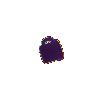

In [9]:
pos = torch.tensor([0.0, 0.0, 0.5],device=device)
quat =  torch.tensor(torch.rand(4,device=device) - 0.5,device=device)

color, radii, num_rendered, tiles_depth_sorted,gaussian_sorted,alpha_tensor=  render(pos, quat)
depth_image = np.moveaxis(color.detach().cpu().numpy(),0,-1)[...,2]
b.show_cloud("1", b.unproject_depth_jit(depth_image, intrinsics).reshape(-1,3))
viz_gt = b.get_depth_image(depth_image)
viz_gt

In [23]:
print(num_rendered)
print(tiles_depth_sorted.shape)
print(gaussian_sorted.shape)
print(alpha_tensor.shape)

24835
torch.Size([24835])
torch.Size([24835])
torch.Size([24835])


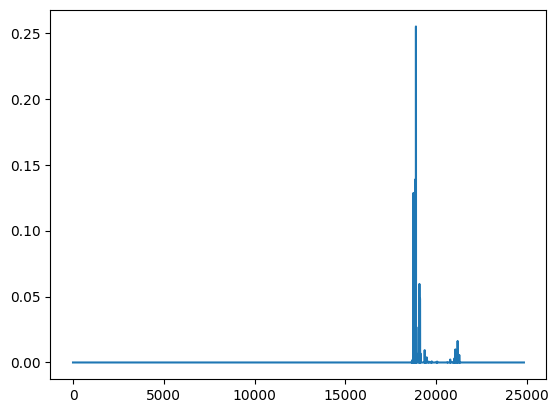

In [21]:
fig = plt.figure()
plt.plot(alpha_tensor.detach().cpu().numpy())

In [14]:
tiles_depth_sorted

tensor([ 69774986716,  69774986716,  69774986716,  ..., 104137094613,
        104137100257, 104137100257])

In [13]:
gaussian_sorted

tensor([ 2639, 11498, 11499,  ..., 14579,  5808, 14576], dtype=torch.int32)

In [12]:
gaussian_sorted.max()

tensor(16762, dtype=torch.int32)

In [39]:
tiles_depth_sorted

tensor([ 69774669731,  69774669731,  69774669846,  ..., 104137279267,
        104137280558, 104137280558])

In [1]:
gaussian_sorted

NameError: name 'gaussian_sorted' is not defined

In [31]:
tiles_depth_sorted

tensor([ 69774669731,  69774669731,  69774669846,  ..., 104137279267,
        104137280558, 104137280558])

In [35]:
torch.unique(tiles_depth_sorted).shape

torch.Size([12227])

In [36]:
16*16

256

In [23]:
gaussian_sorted.max()

tensor(16762, dtype=torch.int32)

In [17]:
tiles_depth_sorted

tensor([ 69774977559,  69774982546,  69774982546,  ..., 104137019522,
        104137020161, 104137020161])

In [8]:
pos = torch.tensor([0.0, 0.0, 0.5],device=device)
quat =  torch.tensor(torch.rand(4,device=device) - 0.5,device=device)

data =  render(pos, quat).detach()
depth_image = np.moveaxis(gt_rendered_image.detach().cpu().numpy(),0,-1)[...,2]
b.show_cloud("1", b.unproject_depth_jit(depth_image, intrinsics).reshape(-1,3))
viz_gt = b.get_depth_image(depth_image)
viz_gt


/var/tmp/ipykernel_282961/1411759165.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quat =  torch.tensor(torch.rand(4,device=device) - 0.5,device=device)
/var/tmp/ipykernel_282961/2915196021.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor( 0.0025 * torch.rand((N, 3)),requires_grad=True,device=device)


ValueError: too many values to unpack (expected 2)

/var/tmp/ipykernel_577859/758192653.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quat =  torch.tensor(quat + torch.rand(4,device=device)*0.1,device=device, requires_grad=True)
/var/tmp/ipykernel_577859/2915196021.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor( 0.0025 * torch.rand((N, 3)),requires_grad=True,device=device)


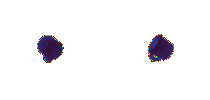

In [130]:
pos = torch.tensor([0.0, 0.0, 0.5],device=device, requires_grad=True)
quat =  torch.tensor(quat + torch.rand(4,device=device)*0.1,device=device, requires_grad=True)
rendered_image =  render(pos, quat)
depth_image = np.moveaxis(rendered_image.detach().cpu().numpy(),0,-1)[...,2]
b.show_cloud("1", b.unproject_depth_jit(depth_image, intrinsics).reshape(-1,3))
viz = b.get_depth_image(depth_image)
parameters_over_time = []
losses_over_time = []
b.hstack_images([viz, viz_gt])


  0%|          | 0/25 [00:00<?, ?it/s]/var/tmp/ipykernel_577859/2915196021.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor( 0.0025 * torch.rand((N, 3)),requires_grad=True,device=device)
0.004769056104123592: 100%|██████████| 25/25 [00:00<00:00, 140.70it/s]


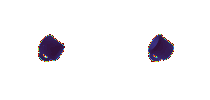

In [141]:

optimizer = torch.optim.Adam([
    {'params': [pos], 'lr': 0.0001, "name": "pos"},
    {'params': [quat], 'lr': 0.001, "name": "quat"},
], lr=0.0, eps=1e-15)


pbar = tqdm(range(25))
for _ in pbar:
    rendered_image =  render(pos, quat)
    loss = torch.abs(gt_rendered_image - rendered_image).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    parameters_over_time.append((pos.detach().clone(),quat.detach().clone()))
    losses_over_time.append(loss.item())
    pbar.set_description(f"{loss.item()}")

depth_image = np.moveaxis(rendered_image.detach().cpu().numpy(),0,-1)[...,2]
b.show_cloud("1", b.unproject_depth_jit(depth_image, intrinsics).reshape(-1,3))
viz = b.get_depth_image(depth_image)
b.hstack_images([viz, viz_gt])



/var/tmp/ipykernel_577859/2915196021.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor( 0.0025 * torch.rand((N, 3)),requires_grad=True,device=device)
100%|██████████| 92/92 [00:23<00:00,  3.84it/s]


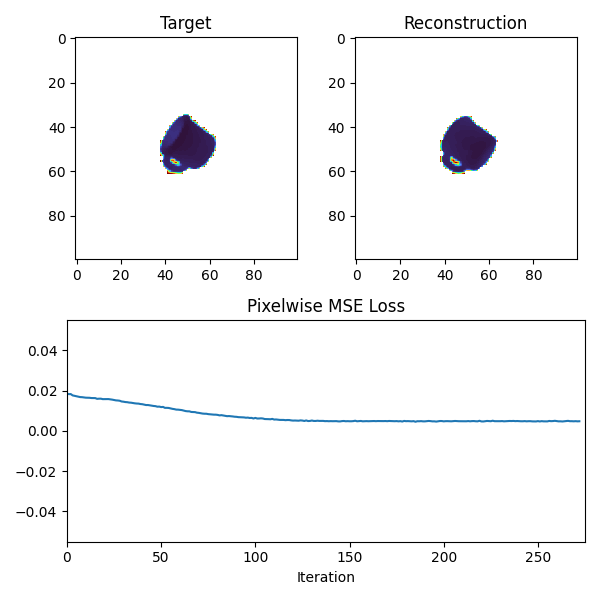

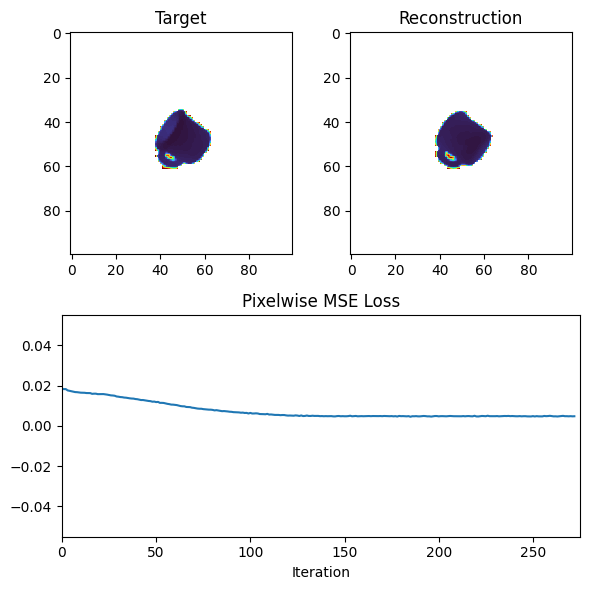

In [142]:
T = 0
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(2,2,1)
ax.set_title("Target")
gt_image = np.moveaxis(gt_rendered_image.detach().cpu().numpy(),0,-1)[...,2]
img1 = ax.imshow(b.preprocess_for_viz(gt_image),cmap=b.cmap)
ax = fig.add_subplot(2,2,2)
parameters = parameters_over_time[T]
rendered_image = render(*parameters)
rendered_image = np.moveaxis(rendered_image.detach().cpu().numpy(),0,-1)[...,2]
img2 = ax.imshow(b.preprocess_for_viz(rendered_image),cmap=b.cmap)
title = ax.set_title(f"Reconstruction")
ax = fig.add_subplot(2,1,2)
line = ax.plot(jnp.arange(T), losses_over_time[:T])
# ax.set_yscale("log")
ax.set_title("Pixelwise MSE Loss")
# ax.set_ylim(0.01, 1000.0)
ax.set_xlabel("Iteration")
ax.set_xlim(0,len(losses_over_time))
fig.tight_layout()

buffs = []
for T in tqdm(range(0,len(losses_over_time),3)):
    parameters = parameters_over_time[T]
    rendered_image = render(*parameters)
    rendered_image = np.moveaxis(rendered_image.detach().cpu().numpy(),0,-1)[...,2]
    img2.set_array(b.preprocess_for_viz(rendered_image))
    line[0].set_xdata(jnp.arange(T))
    line[0].set_ydata(losses_over_time[:T])
    fig.canvas.draw()
    buffs.append(b.pil_image_from_matplotlib(fig))
buffs[-1]

In [143]:
b.make_gif_from_pil_images(buffs, "optimization.gif")